XGBoost Classification - 'real-world' example: UCI Skin Segmentation dataset

STP EI versus STP dEI

https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

In [ ]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 34.5 MB/s 
     |████████████████████████████████| 872 kB 48.5 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=396dad321e08ac8fdf99d3291f71f18f9964674c92ac48a06fdfcc746d757540
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=ab073379677d26605974ba94c2c672cfcd60beda176581bc910bdf243c75fe4c
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [ ]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/content/sample_data/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [ ]:
### Bayesian Optimisation - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

test_perc = 0.1
train_perc = 1 - test_perc
n_est = 5

obj_classifier = 'binary:logistic'
opt = True

eps = 1e-08

In [ ]:
### Objective function:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30 

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds               
        

In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [ ]:
n_start_AcqFunc = max_iter

In [ ]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = 1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = 1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = 1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = 1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.8908732403145235	 0.9925867348688545	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.9925867348688545	 0.9925867348688545	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8923332245535998	 0.9925867348688545	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.9916527108266131	 0.9925867348688545	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.8919387539177265	 0.9925867348688545	    	    
1	 [ 3.91669433  4.82142612 10.99999997  1.          5.72116054  0.68976561]	 0.9961732205209872	 0.9961732205209872	 -0.19246916269257222	 -0.25179593631247055
2	 [ 4.41055757  4.56029584 10.56683146  0.87665714  6.46661551  0.65873223]	 0.891730

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.8757114618327424	 0.9934256013049169	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.9934256013049169	 0.9934256013049169	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8765593454212379	 0.9934256013049169	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.8762147520500736	 0.9934256013049169	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.876795113968712	 0.9934256013049169	    	    
1	 [ 3.62150546  1.93214084 11.24000807  0.63960355  6.41333639  0.56772373]	 0.8762963678411474	 0.9934256013049169	 -0.22035208222233296	 -0.2635098231966843
2	 [ 2.90144773  2.031221   10.81913487  0.7185143   5.55499902  0.76319873]	 0.99

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 0.9072640810852771	 0.9072640810852771	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 0.9053325546118094	 0.9072640810852771	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.9060670777155349	 0.9072640810852771	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 0.905459512623245	 0.9072640810852771	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.9070645808662829	 0.9072640810852771	    	    
1	 [ 6.16039311  7.36796259 12.6269194   0.69677246 10.9999999   0.14072751]	 0.9071235258555423	 0.9072640810852771	 -0.20599516878892557	 -0.252570451662131
2	 [ 5.49029881  7.95860696 12.79683559  0.60482789 11.34675999  0.59023273]	 0.907

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.9654273788737273	 0.9751258412362075	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.9751258412362075	 0.9751258412362075	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 0.8182095107332149	 0.9751258412362075	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.9743777119715524	 0.9751258412362075	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.8085654468032951	 0.9751258412362075	    	    
1	 [ 3.0180958   0.53184668 10.00000002  0.88984494 18.49462016  1.        ]	 0.9951893211670251	 0.9951893211670251	 -0.18681040588358366	 -0.24512090933578515
2	 [ 2.48276337  8.9956263  12.62295307  0.60475054  9.31147497  0.65254276]	 0.817266

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.9034328339914074	 0.9813694058764522	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.9813694058764522	 0.9813694058764522	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9037638164733544	 0.9813694058764522	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.903187990318585	 0.9813694058764522	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.9026529697979975	 0.9813694058764522	    	    
1	 [ 6.22528461  6.91374123  5.52016861  0.6688481  16.70590252  0.50970651]	 0.9048928319014016	 0.9813694058764522	 -0.2347991096997991	 -0.3229831319314016
2	 [ 6.40706044  7.04564168  6.03518318  0.80058961 18.1311773   0.26134865]	 0.903609660

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.828343554751443	 0.9903877129366885	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.839647067574489	 0.9903877129366885	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.9903877129366885	 0.9903877129366885	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8274911397162106	 0.9903877129366885	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 0.8389170745812453	 0.9903877129366885	    	    
1	 [ 5.28678125  6.19813187 14.00000006  0.80678661 13.10411074  0.62784889]	 0.8385860936411312	 0.9903877129366885	 -0.18741918027743426	 -0.24172242608528455
2	 [ 5.38509473  5.54759538 13.99999992  0.79440334 12.08556006  0.66615194]	 0.8392389997203166	 0.

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.9904557002616506	 0.9930673475003069	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.9917932664675032	 0.9930673475003069	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.883414889421213	 0.9930673475003069	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.9792428690012404	 0.9930673475003069	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.9930673475003069	 0.9930673475003069	    	    
1	 [ 1.72288343  7.52342642 13.69457576  0.68102749  4.30542712  0.69633495]	 0.9930084055947133	 0.9930673475003069	 -0.21053032099115218	 -0.26654135980500243
2	 [ 5.95259295  4.88147546 13.81245305  0.65464849  5.39621114  0.9744344 ]	 0.9910315350506

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.8708372474601787	 0.98963962530152	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.9866108407367307	 0.98963962530152	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.872070527278721	 0.98963962530152	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.9881252298840654	 0.98963962530152	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.98963962530152	 0.98963962530152	    	    
1	 [ 6.12069615  7.66064366  8.00043024  0.76135949 13.          0.93390428]	 0.9866108407367307	 0.98963962530152	 -0.19679934008166952	 -0.20251710347444607
2	 [ 9.60750373  4.13491703 13.36678169  0.66305098  7.31664995  0.78167847]	 0.988215912680167

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 0.9048338034475906	 0.9955928561354164	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 0.9047612611372433	 0.9955928561354164	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.9955928561354164	 0.9955928561354164	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.9910904971028934	 0.9955928561354164	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.9953842891169714	 0.9955928561354164	    	    
1	 [ 3.7812739   2.9330924  13.46513249  0.66579042  1.5327995   0.1       ]	 0.904530022597462	 0.9955928561354164	 -0.2054548385412082	 -0.2490166349253499
2	 [ 8.15733943  9.54866272 13.27016315  0.89291495 10.18874623  0.73154587]	 0.995

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 0.7954258523050255	 0.9704874975832413	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.9704874975832413	 0.9704874975832413	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.9640172976993628	 0.9704874975832413	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.8084613990917093	 0.9704874975832413	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 0.8000914273985783	 0.9704874975832413	    	    
1	 [ 6.97211981  3.15621373 12.6647428   0.76829459 17.49819261  0.79197815]	 0.970995318836154	 0.970995318836154	 -0.17367849646454153	 -0.22929904148474545
2	 [ 6.4491271   2.34011885 12.41594293  0.65585511 17.41368267  0.92350956]	 0.97065979

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8646663465239206	 0.9899932222569884	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.981382975547338	 0.9899932222569884	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.9899932222569884	 0.9899932222569884	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.9895488799070045	 0.9899932222569884	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.8692729987278183	 0.9899932222569884	    	    
1	 [ 3.63150368  0.15474954  5.40076033  0.78647479 13.59973897  0.7105013 ]	 0.9812786937855261	 0.9899932222569884	 -0.22150026631987302	 -0.27490898008920267
2	 [ 7.23727415  1.71604325  9.62033279  0.78416143 17.2406822   0.51069378]	 0.8

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.7992888930200872	 0.9929857748805528	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.8001140962474045	 0.9929857748805528	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.7995201313542909	 0.9929857748805528	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.9929857748805528	 0.9929857748805528	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.7989896705473761	 0.9929857748805528	    	    
1	 [ 5.52039037  4.85376396  7.00000003  0.97887813 17.00000079  0.78811988]	 0.9929857748805528	 0.9929857748805528	 -0.1568886546986255	 -0.20931138389540596
2	 [ 5.78341384  5.16435048  7.4842209   0.90624161 17.48527819  0.72420642]	 0.9931036

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.9817003217512204	 0.9817003217512204	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 0.8502067725819831	 0.9817003217512204	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.8514763172341846	 0.9817003217512204	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.8514264451089183	 0.9817003217512204	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 0.8506737814166495	 0.9817003217512204	    	    
1	 [ 3.1347754   0.43505409 10.30572973  0.77420891 10.77718308  0.40827836]	 0.8513221591327635	 0.9817003217512204	 -0.17956122323202428	 -0.21528207609330963
2	 [ 3.32718183  0.24267769 10.69743553  0.82342077  9.21023347  0.50773226]	 0.

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.8693274088783083	 0.9950215588576624	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.9949218078230656	 0.9950215588576624	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.8696221759680363	 0.9950215588576624	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.9950215588576624	 0.9950215588576624	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.8679354863833263	 0.9950215588576624	    	    
1	 [ 2.49111197  3.02510477  7.25442422  0.84177605 13.50293563  0.78639777]	 0.9936613295591595	 0.9950215588576624	 -0.22851699631917172	 -0.24749311240441338
2	 [ 2.35980402  2.77480313  8.21492105  0.84651376 13.5586575   0.99961525]	 0.995116

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.994817522360855	 0.994817522360855	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 0.892201745168735	 0.994817522360855	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 0.8919750455792771	 0.994817522360855	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8902792777855535	 0.994817522360855	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 0.891829946156987	 0.994817522360855	    	    
1	 [ 2.97964868  5.45677403  9.          0.86651536 18.          0.90648149]	 0.9954341598031935	 0.9954341598031935	 -0.18383211056357224	 -0.18383211056357224
2	 [ 3.89825034  5.4802931   9.90036874  0.86040764 18.45013308  0.55939088]	 0.89191156862933

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 0.8661220423091164	 0.8688832572016532	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 0.86672957738706	 0.8688832572016532	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.8686973743475741	 0.8688832572016532	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 0.8688832572016532	 0.8688832572016532	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 0.868624806751168	 0.8688832572016532	    	    
1	 [ 2.20494513  1.82621042 11.87489351  0.53292761  8.29078794  0.27826674]	 0.8685658666957738	 0.8688832572016532	 -0.20259713077353814	 -0.2455230130667371
2	 [ 2.22695674  2.2143529  11.01045764  0.54529029  7.79428223  0.29348648]	 0.8682666162644935

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.9913579828994393	 0.9913579828994393	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.8889281830243577	 0.9913579828994393	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8873004452129717	 0.9913579828994393	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.8860354351939618	 0.9913579828994393	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.8894133273081246	 0.9913579828994393	    	    
1	 [ 5.66960908  5.81083266 12.50011205  0.73870631 18.50010637  0.39454395]	 0.8890868808984133	 0.9913579828994393	 -0.181983109930482	 -0.29018330849457313
2	 [ 3.70752933  4.65696884 10.72378934  0.99143995 14.00000695  0.92197055]	 0.99143959

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.8647343685915162	 0.9901111073016418	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8682755064726887	 0.9901111073016418	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.8695133309977306	 0.9901111073016418	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8676044694671123	 0.9901111073016418	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.9901111073016418	 0.9901111073016418	    	    
1	 [6.537881   6.02731089 7.0018157  0.61167795 3.50091072 0.40648021]	 0.8667067065581311	 0.9901111073016418	 -0.17963729735890052	 -0.2638173681120067
2	 [ 6.22893242  2.63952202 13.44513501  0.7939711   4.55423411  0.80209498]	 0.9902652683839399	 0.99026

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.8398193676007087	 0.9838858038212693	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9834958414018518	 0.9838858038212693	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 0.8406672389573302	 0.9838858038212693	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.9823895144553022	 0.9838858038212693	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.9838858038212693	 0.9838858038212693	    	    
1	 [ 1.56753702  6.55093337 12.499787    0.69169987 10.49978675  0.30028563]	 0.8400914096161062	 0.9838858038212693	 -0.20623499608477117	 -0.28083990283296417
2	 [ 0.93145832  5.84813564  6.26544943  0.58428761 18.46885223  0.73555877]	 0.982679

In [ ]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.9747268389480196	 0.9747268389480196	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.9702380665465439	 0.9747268389480196	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 0.8082118172637596	 0.9747268389480196	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.8131630697256746	 0.9747268389480196	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.8145369111468609	 0.9747268389480196	    	    
1	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 0.8094496288374055	 0.9747268389480196	 -0.17421656146335146	 -0.17421656146335146
2	 [ 5.15433733  5.3212415   8.43456459  0.723665   17.42141308  0.42589952]	 0.812677

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.8908732403145235	 0.9925867348688545	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.9925867348688545	 0.9925867348688545	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8923332245535998	 0.9925867348688545	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.9916527108266131	 0.9925867348688545	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.8919387539177265	 0.9925867348688545	    	    
1	 [ 4.1417927   0.49953459 11.          0.83189732  7.          0.81316323]	 0.9927318279182357	 0.9927318279182357	 -0.19246916269257222	 -0.25179593631247055
2	 [8.44734445 9.05392319 8.         0.71498395 8.         0.81874323]	 0.989748387012

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.8757114618327424	 0.9934256013049169	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.9934256013049169	 0.9934256013049169	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8765593454212379	 0.9934256013049169	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.8762147520500736	 0.9934256013049169	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.876795113968712	 0.9934256013049169	    	    
1	 [ 4.06275043  0.27202366 10.          0.71576889 12.          0.82023252]	 0.9932533105296942	 0.9934256013049169	 -0.22035208222233296	 -0.2635098231966843
2	 [ 3.64686916  1.7936188  11.97121195  0.8221854   6.56645296  0.64417261]	 0.87

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 0.9072640810852771	 0.9072640810852771	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 0.9053325546118094	 0.9072640810852771	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.9060670777155349	 0.9072640810852771	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 0.905459512623245	 0.9072640810852771	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.9070645808662829	 0.9072640810852771	    	    
1	 [ 7.25669624  7.84936703 12.          0.92548571 11.          0.18081178]	 0.9069376221353254	 0.9072640810852771	 -0.20599516878892557	 -0.252570451662131
2	 [ 5.72860711  1.96462961 11.          0.9255565   1.          0.65739455]	 0.906

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.9654273788737273	 0.9751258412362075	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.9751258412362075	 0.9751258412362075	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 0.8182095107332149	 0.9751258412362075	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.9743777119715524	 0.9751258412362075	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.8085654468032951	 0.9751258412362075	    	    
1	 [3.08794564 7.53212085 8.         0.70431339 9.         0.18112756]	 0.8175067235861329	 0.9751258412362075	 -0.18681040588358366	 -0.24512090933578515
2	 [ 3.19425195  7.29992989 14.          0.55667845 10.          0.61464222]	 0.816699656733

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.9034328339914074	 0.9813694058764522	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.9813694058764522	 0.9813694058764522	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9037638164733544	 0.9813694058764522	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.903187990318585	 0.9813694058764522	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.9026529697979975	 0.9813694058764522	    	    
1	 [ 6.4698285   7.31422681  6.0463331   0.61923843 15.0463331   0.69083698]	 0.984429908615413	 0.984429908615413	 -0.2347991096997991	 -0.3229831319314016
2	 [ 8.20256175 10.          7.83472668  1.          4.22500209  1.        ]	 0.99344822605

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None, eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.828343554751443	 0.9903877129366885	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.839647067574489	 0.9903877129366885	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.9903877129366885	 0.9903877129366885	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8274911397162106	 0.9903877129366885	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 0.8389170745812453	 0.9903877129366885	    	    
1	 [5.66084171 5.23993941 5.20815579 1.         3.20815579 0.69207397]	 0.9854364698285591	 0.9903877129366885	 -0.18741918027743426	 -0.24172242608528455
2	 [ 5.98264084  5.29699202 14.36258093  1.         13.1536295   0.72131414]	 0.9947495125251331	 0.994749

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.9904557002616506	 0.9930673475003069	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.9917932664675032	 0.9930673475003069	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.883414889421213	 0.9930673475003069	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.9792428690012404	 0.9930673475003069	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.9930673475003069	 0.9930673475003069	    	    
1	 [ 2.00662851  6.97356508 13.32387546  0.90623379  5.32387546  0.84047357]	 0.9932668484388231	 0.9932668484388231	 -0.21053032099115218	 -0.26654135980500243
2	 [ 5.16624685  6.49143281 11.97614771  1.          5.27176781  0.87795498]	 0.9793607830323

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.8708372474601787	 0.98963962530152	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.9866108407367307	 0.98963962530152	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.872070527278721	 0.98963962530152	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.9881252298840654	 0.98963962530152	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.98963962530152	 0.98963962530152	    	    
1	 [ 4.68106065  8.14661611  6.          0.80383807 13.          0.57495145]	 0.8709868749371736	 0.98963962530152	 -0.19679934008166952	 -0.20251710347444607
2	 [2.77238236 7.80291345 7.10405488 1.         9.10405488 0.71776312]	 0.9833825292278442	 0.9

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 0.9048338034475906	 0.9955928561354164	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 0.9047612611372433	 0.9955928561354164	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.9955928561354164	 0.9955928561354164	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.9910904971028934	 0.9955928561354164	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.9953842891169714	 0.9955928561354164	    	    
1	 [ 4.7356788   4.41653184 12.          0.72177191  3.          0.40587078]	 0.9053098849406724	 0.9955928561354164	 -0.2054548385412082	 -0.2490166349253499
2	 [ 6.73288776  5.50533795  8.          0.58701646 14.          0.2964145 ]	 0.90

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 0.7954258523050255	 0.9704874975832413	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.9704874975832413	 0.9704874975832413	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.9640172976993628	 0.9704874975832413	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.8084613990917093	 0.9704874975832413	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 0.8000914273985783	 0.9704874975832413	    	    
1	 [ 6.7244911   0.77055265 10.          0.67779069 14.          0.63914662]	 0.8092503336821798	 0.9704874975832413	 -0.17367849646454153	 -0.22929904148474545
2	 [ 6.94717166  3.72584546 12.94649849  0.95093545 16.18687075  0.89325556]	 0.971471

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8646663465239206	 0.9899932222569884	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.981382975547338	 0.9899932222569884	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.9899932222569884	 0.9899932222569884	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.9895488799070045	 0.9899932222569884	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.8692729987278183	 0.9899932222569884	    	    
1	 [ 3.19367707  0.70382595  5.          0.96192493 15.          0.91486029]	 0.981836385621872	 0.9899932222569884	 -0.22150026631987302	 -0.27490898008920267
2	 [ 4.24205084  3.57981742 13.43334622  1.         14.43334622  0.54495568]	 0.84

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.7992888930200872	 0.9929857748805528	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.8001140962474045	 0.9929857748805528	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.7995201313542909	 0.9929857748805528	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.9929857748805528	 0.9929857748805528	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.7989896705473761	 0.9929857748805528	    	    
1	 [3.21967588 9.71325294 5.         0.82480233 4.         0.44392894]	 0.7980012348128115	 0.9929857748805528	 -0.1568886546986255	 -0.20931138389540596
2	 [ 5.23215032  9.61885387 13.39289443  1.          4.39289443  0.98773072]	 0.9898254832806

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.9817003217512204	 0.9817003217512204	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 0.8502067725819831	 0.9817003217512204	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.8514763172341846	 0.9817003217512204	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.8514264451089183	 0.9817003217512204	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 0.8506737814166495	 0.9817003217512204	    	    
1	 [ 6.73294685  7.08133568 10.          0.50492272 19.          0.42645371]	 0.8490097916202115	 0.9817003217512204	 -0.17956122323202428	 -0.21528207609330963
2	 [ 7.20253686  2.4556061  11.9955233   1.         13.0419767   0.78435901]	 0.

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.8693274088783083	 0.9950215588576624	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.9949218078230656	 0.9950215588576624	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.8696221759680363	 0.9950215588576624	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.9950215588576624	 0.9950215588576624	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.8679354863833263	 0.9950215588576624	    	    
1	 [ 4.34197661  7.60557613 13.          0.85954801 11.          0.4707788 ]	 0.8684750000104074	 0.9950215588576624	 -0.22851699631917172	 -0.24749311240441338
2	 [ 4.21306371  9.89204618 12.79247148  0.91318695 12.26703411  1.        ]	 0.996109

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.994817522360855	 0.994817522360855	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 0.892201745168735	 0.994817522360855	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 0.8919750455792771	 0.994817522360855	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8902792777855535	 0.994817522360855	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 0.891829946156987	 0.994817522360855	    	    
1	 [ 2.97964868  5.45677403  9.          0.86651536 18.          0.90648149]	 0.9954341598031935	 0.9954341598031935	 -0.18383211056357224	 -0.18383211056357224
2	 [ 4.80056824  8.95139228 11.98701003  0.88071682 15.40075051  0.52619109]	 0.89296347586603

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 0.8661220423091164	 0.8688832572016532	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 0.86672957738706	 0.8688832572016532	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.8686973743475741	 0.8688832572016532	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 0.8688832572016532	 0.8688832572016532	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 0.868624806751168	 0.8688832572016532	    	    
1	 [ 4.12112552  5.88694401  6.20622391  0.92929982 19.20622391  0.44250112]	 0.868080752323564	 0.8688832572016532	 -0.20259713077353814	 -0.2455230130667371
2	 [3.31186698 4.47895967 6.93349611 0.84169184 4.00110309 0.99648176]	 0.9848787912519755	 0.984

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.9913579828994393	 0.9913579828994393	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.8889281830243577	 0.9913579828994393	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8873004452129717	 0.9913579828994393	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.8860354351939618	 0.9913579828994393	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.8894133273081246	 0.9913579828994393	    	    
1	 [5.68485287 1.86041213 6.         0.70199511 6.         0.28009919]	 0.8870238729843034	 0.9913579828994393	 -0.181983109930482	 -0.29018330849457313
2	 [4.38410165 1.89816424 8.         0.60190629 6.         0.42907654]	 0.890320160408589	 0.9

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.9053597934531938	 0.9956064616796129	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.9053280306686589	 0.9956064616796129	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.9056816886807078	 0.9956064616796129	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.9061985863952235	 0.9956064616796129	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.9956064616796129	 0.9956064616796129	    	    
1	 [ 6.47390501  4.8826822  14.          0.95955642  4.          0.67306823]	 0.9956518005079424	 0.9956518005079424	 -0.19094492424113466	 -0.284200792592407
2	 [ 4.61282502  6.17977434 11.21530037  0.96435165 13.05812908  0.92494605]	 0.9955248456829613	 0.

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.8398193676007087	 0.9838858038212693	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9834958414018518	 0.9838858038212693	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 0.8406672389573302	 0.9838858038212693	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.9823895144553022	 0.9838858038212693	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.9838858038212693	 0.9838858038212693	    	    
1	 [ 2.44158416  8.66688009 13.          0.98568488 12.          0.74410703]	 0.9859895899249365	 0.9859895899249365	 -0.20623499608477117	 -0.28083990283296417
2	 [ 1.88394623  4.02313935 11.          0.75238976 12.          0.62517259]	 0.840581

In [ ]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.9747268389480196	 0.9747268389480196	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.9702380665465439	 0.9747268389480196	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 0.8082118172637596	 0.9747268389480196	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.8131630697256746	 0.9747268389480196	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.8145369111468609	 0.9747268389480196	    	    
1	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 0.8094496288374055	 0.9747268389480196	 -0.17421656146335146	 -0.17421656146335146
2	 [6.687849   2.4162364  8.         0.83583695 7.         0.46477208]	 0.813679963842

In [ ]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-5.8146787018589094, -5.626799898915486)

In [ ]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-5.63947467558779, -5.7966058842892165)

In [ ]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-5.447421419748254, -5.51603837804615)

In [ ]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-5.7862133550880195, -5.783263018515833)

In [ ]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-4.127773489195458, -5.61802283399347)

In [ ]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-5.521691993349673, -5.548115006157481)

In [ ]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-5.730203433021574, -5.9777342878571424)

In [ ]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-5.383212923296898, -5.548115692333056)

In [ ]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-5.606850439699572, -5.819249661533233)

In [ ]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-5.347339055496122, -5.345436268634539)

In [ ]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-4.604492641272199, -5.465479340009719)

In [ ]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-5.000717363680608, -5.498162273609588)

In [ ]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-5.451642216893102, -5.465479607289595)

In [ ]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-5.340694052081528, -5.6230294356142645)

In [ ]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-5.389152729996303, -5.631851294098732)

In [ ]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-5.527377727992174, -5.7067384881884315)

In [ ]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-5.400136317347517, -5.351155113789653)

In [ ]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-5.543470268248431, -5.726023203446448)

In [ ]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-4.495155279037656, -5.640750802372977)

In [ ]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-5.266856573078755, -5.599469934603467)

In [ ]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

stp1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx1 = np.asarray(gp1_results[4:5][0])[0]
median_approx1 = np.asarray(gp1_results[9:10][0])[0]
upper_approx1 = np.asarray(gp1_results[14:15][0])[0]

lower_exact1 = np.asarray(stp1_results[4:5][0])[0]
median_exact1 = np.asarray(stp1_results[9:10][0])[0]
upper_exact1 = np.asarray(stp1_results[14:15][0])[0]


In [ ]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

stp11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx11 = np.asarray(gp11_results[4:5][0])[0]
median_approx11 = np.asarray(gp11_results[9:10][0])[0]
upper_approx11 = np.asarray(gp11_results[14:15][0])[0]

lower_exact11 = np.asarray(stp11_results[4:5][0])[0]
median_exact11 = np.asarray(stp11_results[9:10][0])[0]
upper_exact11 = np.asarray(stp11_results[14:15][0])[0]


In [ ]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

stp21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx21 = np.asarray(gp21_results[4:5][0])[0]
median_approx21 = np.asarray(gp21_results[9:10][0])[0]
upper_approx21 = np.asarray(gp21_results[14:15][0])[0]

lower_exact21 = np.asarray(stp21_results[4:5][0])[0]
median_exact21 = np.asarray(stp21_results[9:10][0])[0]
upper_exact21 = np.asarray(stp21_results[14:15][0])[0]


In [ ]:
# Iteration31 :

slice31 = 30

gp31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

stp31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx31 = np.asarray(gp31_results[4:5][0])[0]
median_approx31 = np.asarray(gp31_results[9:10][0])[0]
upper_approx31 = np.asarray(gp31_results[14:15][0])[0]

lower_exact31 = np.asarray(stp31_results[4:5][0])[0]
median_exact31 = np.asarray(stp31_results[9:10][0])[0]
upper_exact31 = np.asarray(stp31_results[14:15][0])[0]


In [ ]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

stp2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx2 = np.asarray(gp2_results[4:5][0])[0]
median_approx2 = np.asarray(gp2_results[9:10][0])[0]
upper_approx2 = np.asarray(gp2_results[14:15][0])[0]

lower_exact2 = np.asarray(stp2_results[4:5][0])[0]
median_exact2 = np.asarray(stp2_results[9:10][0])[0]
upper_exact2 = np.asarray(stp2_results[14:15][0])[0]


In [ ]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

stp12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx12 = np.asarray(gp12_results[4:5][0])[0]
median_approx12 = np.asarray(gp12_results[9:10][0])[0]
upper_approx12 = np.asarray(gp12_results[14:15][0])[0]

lower_exact12 = np.asarray(stp12_results[4:5][0])[0]
median_exact12 = np.asarray(stp12_results[9:10][0])[0]
upper_exact12 = np.asarray(stp12_results[14:15][0])[0]


In [ ]:
# Iteration22 :

slice22 = 21

gp22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

stp22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx22 = np.asarray(gp22_results[4:5][0])[0]
median_approx22 = np.asarray(gp22_results[9:10][0])[0]
upper_approx22 = np.asarray(gp22_results[14:15][0])[0]

lower_exact22 = np.asarray(stp22_results[4:5][0])[0]
median_exact22 = np.asarray(stp22_results[9:10][0])[0]
upper_exact22 = np.asarray(stp22_results[14:15][0])[0]


In [ ]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

stp3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx3 = np.asarray(gp3_results[4:5][0])[0]
median_approx3 = np.asarray(gp3_results[9:10][0])[0]
upper_approx3 = np.asarray(gp3_results[14:15][0])[0]

lower_exact3 = np.asarray(stp3_results[4:5][0])[0]
median_exact3 = np.asarray(stp3_results[9:10][0])[0]
upper_exact3 = np.asarray(stp3_results[14:15][0])[0]


In [ ]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

stp13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx13 = np.asarray(gp13_results[4:5][0])[0]
median_approx13 = np.asarray(gp13_results[9:10][0])[0]
upper_approx13 = np.asarray(gp13_results[14:15][0])[0]

lower_exact13 = np.asarray(stp13_results[4:5][0])[0]
median_exact13 = np.asarray(stp13_results[9:10][0])[0]
upper_exact13 = np.asarray(stp13_results[14:15][0])[0]


In [ ]:
# Iteration23 :

slice23 = 22

gp23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

stp23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx23 = np.asarray(gp23_results[4:5][0])[0]
median_approx23 = np.asarray(gp23_results[9:10][0])[0]
upper_approx23 = np.asarray(gp23_results[14:15][0])[0]

lower_exact23 = np.asarray(stp23_results[4:5][0])[0]
median_exact23 = np.asarray(stp23_results[9:10][0])[0]
upper_exact23 = np.asarray(stp23_results[14:15][0])[0]


In [ ]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

stp4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx4 = np.asarray(gp4_results[4:5][0])[0]
median_approx4 = np.asarray(gp4_results[9:10][0])[0]
upper_approx4 = np.asarray(gp4_results[14:15][0])[0]

lower_exact4 = np.asarray(stp4_results[4:5][0])[0]
median_exact4 = np.asarray(stp4_results[9:10][0])[0]
upper_exact4 = np.asarray(stp4_results[14:15][0])[0]


In [ ]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

stp14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx14 = np.asarray(gp14_results[4:5][0])[0]
median_approx14 = np.asarray(gp14_results[9:10][0])[0]
upper_approx14 = np.asarray(gp14_results[14:15][0])[0]

lower_exact14 = np.asarray(stp14_results[4:5][0])[0]
median_exact14 = np.asarray(stp14_results[9:10][0])[0]
upper_exact14 = np.asarray(stp14_results[14:15][0])[0]


In [ ]:
# Iteration24 :

slice24 = 23

gp24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

stp24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx24 = np.asarray(gp24_results[4:5][0])[0]
median_approx24 = np.asarray(gp24_results[9:10][0])[0]
upper_approx24 = np.asarray(gp24_results[14:15][0])[0]

lower_exact24 = np.asarray(stp24_results[4:5][0])[0]
median_exact24 = np.asarray(stp24_results[9:10][0])[0]
upper_exact24 = np.asarray(stp24_results[14:15][0])[0]


In [ ]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

stp5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx5 = np.asarray(gp5_results[4:5][0])[0]
median_approx5 = np.asarray(gp5_results[9:10][0])[0]
upper_approx5 = np.asarray(gp5_results[14:15][0])[0]

lower_exact5 = np.asarray(stp5_results[4:5][0])[0]
median_exact5 = np.asarray(stp5_results[9:10][0])[0]
upper_exact5 = np.asarray(stp5_results[14:15][0])[0]


In [ ]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

stp15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx15 = np.asarray(gp15_results[4:5][0])[0]
median_approx15 = np.asarray(gp15_results[9:10][0])[0]
upper_approx15 = np.asarray(gp15_results[14:15][0])[0]

lower_exact15 = np.asarray(stp15_results[4:5][0])[0]
median_exact15 = np.asarray(stp15_results[9:10][0])[0]
upper_exact15 = np.asarray(stp15_results[14:15][0])[0]


In [ ]:
# Iteration25 :

slice25 = 24

gp25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

stp25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx25 = np.asarray(gp25_results[4:5][0])[0]
median_approx25 = np.asarray(gp25_results[9:10][0])[0]
upper_approx25 = np.asarray(gp25_results[14:15][0])[0]

lower_exact25 = np.asarray(stp25_results[4:5][0])[0]
median_exact25 = np.asarray(stp25_results[9:10][0])[0]
upper_exact25= np.asarray(stp25_results[14:15][0])[0]


In [ ]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

stp6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx6 = np.asarray(gp6_results[4:5][0])[0]
median_approx6 = np.asarray(gp6_results[9:10][0])[0]
upper_approx6 = np.asarray(gp6_results[14:15][0])[0]

lower_exact6 = np.asarray(stp6_results[4:5][0])[0]
median_exact6 = np.asarray(stp6_results[9:10][0])[0]
upper_exact6 = np.asarray(stp6_results[14:15][0])[0]


In [ ]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

stp16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx16 = np.asarray(gp16_results[4:5][0])[0]
median_approx16 = np.asarray(gp16_results[9:10][0])[0]
upper_approx16 = np.asarray(gp16_results[14:15][0])[0]

lower_exact16 = np.asarray(stp16_results[4:5][0])[0]
median_exact16 = np.asarray(stp16_results[9:10][0])[0]
upper_exact16 = np.asarray(stp16_results[14:15][0])[0]


In [ ]:
# Iteration26 :

slice26 = 25

gp26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

stp26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx26 = np.asarray(gp26_results[4:5][0])[0]
median_approx26 = np.asarray(gp26_results[9:10][0])[0]
upper_approx26 = np.asarray(gp26_results[14:15][0])[0]

lower_exact26 = np.asarray(stp26_results[4:5][0])[0]
median_exact26 = np.asarray(stp26_results[9:10][0])[0]
upper_exact26 = np.asarray(stp26_results[14:15][0])[0]


In [ ]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

stp7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx7 = np.asarray(gp7_results[4:5][0])[0]
median_approx7 = np.asarray(gp7_results[9:10][0])[0]
upper_approx7 = np.asarray(gp7_results[14:15][0])[0]

lower_exact7 = np.asarray(stp7_results[4:5][0])[0]
median_exact7 = np.asarray(stp7_results[9:10][0])[0]
upper_exact7 = np.asarray(stp7_results[14:15][0])[0]


In [ ]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

stp17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx17 = np.asarray(gp17_results[4:5][0])[0]
median_approx17 = np.asarray(gp17_results[9:10][0])[0]
upper_approx17 = np.asarray(gp17_results[14:15][0])[0]

lower_exact17 = np.asarray(stp17_results[4:5][0])[0]
median_exact17 = np.asarray(stp17_results[9:10][0])[0]
upper_exact17 = np.asarray(stp17_results[14:15][0])[0]


In [ ]:
# Iteration27 :

slice27 = 26

gp27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

stp27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx27 = np.asarray(gp27_results[4:5][0])[0]
median_approx27 = np.asarray(gp27_results[9:10][0])[0]
upper_approx27 = np.asarray(gp27_results[14:15][0])[0]

lower_exact27 = np.asarray(stp27_results[4:5][0])[0]
median_exact27 = np.asarray(stp27_results[9:10][0])[0]
upper_exact27 = np.asarray(stp27_results[14:15][0])[0]


In [ ]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

stp8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx8 = np.asarray(gp8_results[4:5][0])[0]
median_approx8 = np.asarray(gp8_results[9:10][0])[0]
upper_approx8 = np.asarray(gp8_results[14:15][0])[0]

lower_exact8 = np.asarray(stp8_results[4:5][0])[0]
median_exact8 = np.asarray(stp8_results[9:10][0])[0]
upper_exact8 = np.asarray(stp8_results[14:15][0])[0]


In [ ]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

stp18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx18 = np.asarray(gp18_results[4:5][0])[0]
median_approx18 = np.asarray(gp18_results[9:10][0])[0]
upper_approx18 = np.asarray(gp18_results[14:15][0])[0]

lower_exact18 = np.asarray(stp18_results[4:5][0])[0]
median_exact18 = np.asarray(stp18_results[9:10][0])[0]
upper_exact18 = np.asarray(stp18_results[14:15][0])[0]


In [ ]:
# Iteration28 :

slice28 = 27

gp28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

stp28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx28 = np.asarray(gp28_results[4:5][0])[0]
median_approx28 = np.asarray(gp28_results[9:10][0])[0]
upper_approx28 = np.asarray(gp28_results[14:15][0])[0]

lower_exact28 = np.asarray(stp28_results[4:5][0])[0]
median_exact28 = np.asarray(stp28_results[9:10][0])[0]
upper_exact28 = np.asarray(stp28_results[14:15][0])[0]


In [ ]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

stp9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx9 = np.asarray(gp9_results[4:5][0])[0]
median_approx9 = np.asarray(gp9_results[9:10][0])[0]
upper_approx9 = np.asarray(gp9_results[14:15][0])[0]

lower_exact9 = np.asarray(stp9_results[4:5][0])[0]
median_exact9 = np.asarray(stp9_results[9:10][0])[0]
upper_exact9 = np.asarray(stp9_results[14:15][0])[0]


In [ ]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

stp19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx19 = np.asarray(gp19_results[4:5][0])[0]
median_approx19 = np.asarray(gp19_results[9:10][0])[0]
upper_approx19 = np.asarray(gp19_results[14:15][0])[0]

lower_exact19 = np.asarray(stp19_results[4:5][0])[0]
median_exact19 = np.asarray(stp19_results[9:10][0])[0]
upper_exact19 = np.asarray(stp19_results[14:15][0])[0]


In [ ]:
# Iteration29 :

slice29 = 28

gp29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

stp29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx29 = np.asarray(gp29_results[4:5][0])[0]
median_approx29 = np.asarray(gp29_results[9:10][0])[0]
upper_approx29 = np.asarray(gp29_results[14:15][0])[0]

lower_exact29 = np.asarray(stp29_results[4:5][0])[0]
median_exact29 = np.asarray(stp29_results[9:10][0])[0]
upper_exact29 = np.asarray(stp29_results[14:15][0])[0]


In [ ]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

stp10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx10 = np.asarray(gp10_results[4:5][0])[0]
median_approx10 = np.asarray(gp10_results[9:10][0])[0]
upper_approx10 = np.asarray(gp10_results[14:15][0])[0]

lower_exact10 = np.asarray(stp10_results[4:5][0])[0]
median_exact10 = np.asarray(stp10_results[9:10][0])[0]
upper_exact10 = np.asarray(stp10_results[14:15][0])[0]


In [ ]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

stp20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx20 = np.asarray(gp20_results[4:5][0])[0]
median_approx20 = np.asarray(gp20_results[9:10][0])[0]
upper_approx20 = np.asarray(gp20_results[14:15][0])[0]

lower_exact20 = np.asarray(stp20_results[4:5][0])[0]
median_exact20 = np.asarray(stp20_results[9:10][0])[0]
upper_exact20 = np.asarray(stp20_results[14:15][0])[0]


In [ ]:
# Iteration30 :

slice30 = 29

gp30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

stp30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx30 = np.asarray(gp30_results[4:5][0])[0]
median_approx30 = np.asarray(gp30_results[9:10][0])[0]
upper_approx30 = np.asarray(gp30_results[14:15][0])[0]

lower_exact30 = np.asarray(stp30_results[4:5][0])[0]
median_exact30 = np.asarray(stp30_results[9:10][0])[0]
upper_exact30 = np.asarray(stp30_results[14:15][0])[0]


In [ ]:
### Summarise arrays: 'Approx'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31]


In [ ]:
### Summarise arrays: 'Exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31]


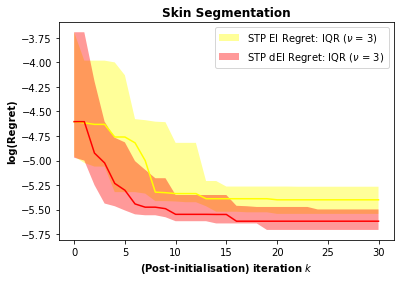

In [ ]:
### Visualise!

title = 'Skin Segmentation'

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='STP EI Regret: IQR ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='STP dEI Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
